In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.reset_default_graph()

In [2]:
samples = 1000
times = [i*1e-2 for i in range(samples+1)]

sin = np.sin(times[:-1]) ## input data
sin_next = np.sin(times[1:]) ## (1000,)
sin_next = np.reshape(sin_next,[-1,1])## output data
print(sin_next.shape) ##(1000, 1)

(1000, 1)


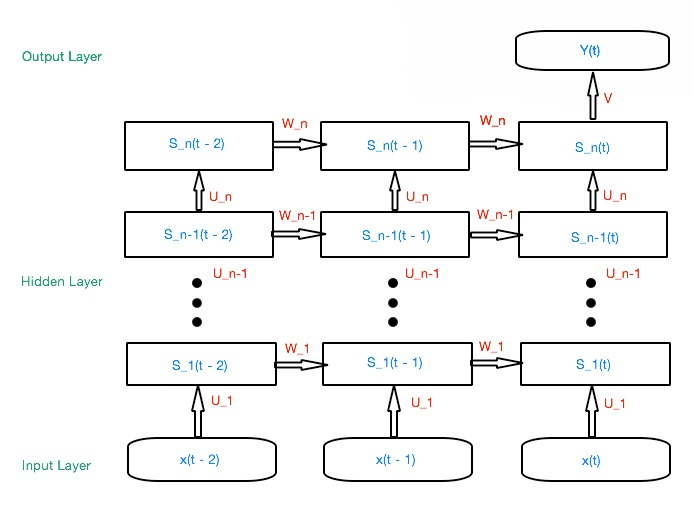

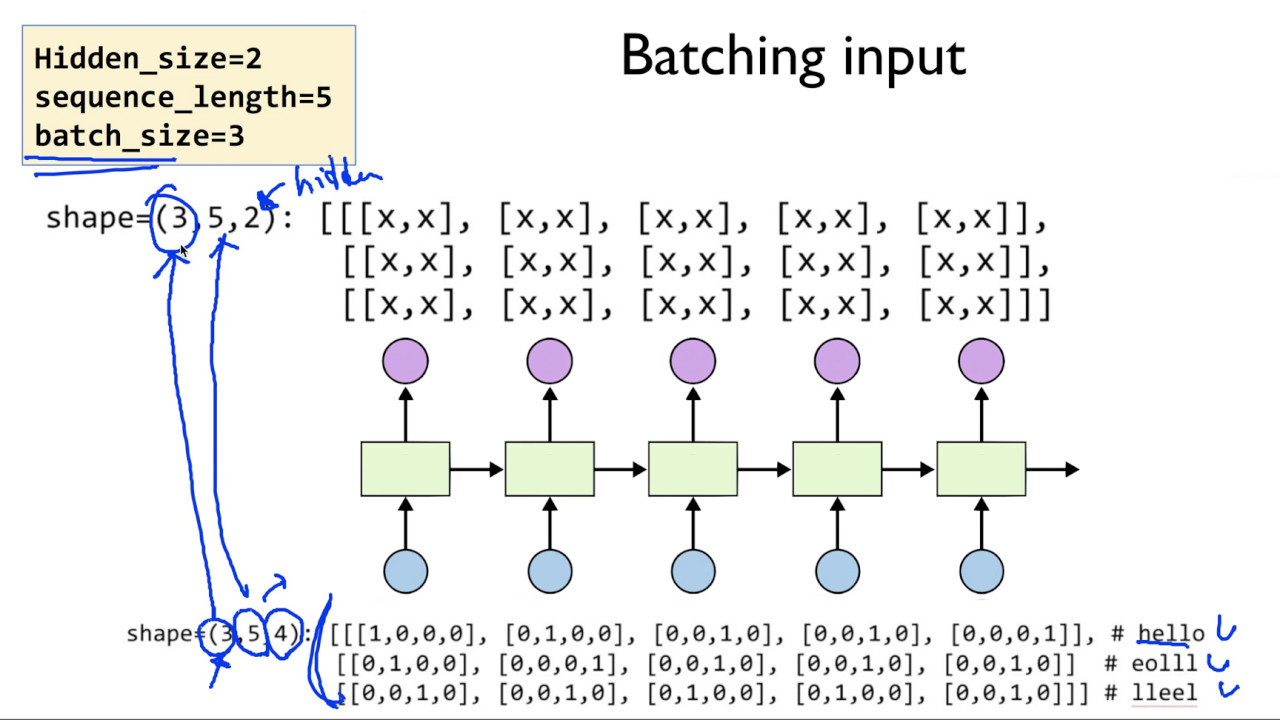

## cell 내부구조

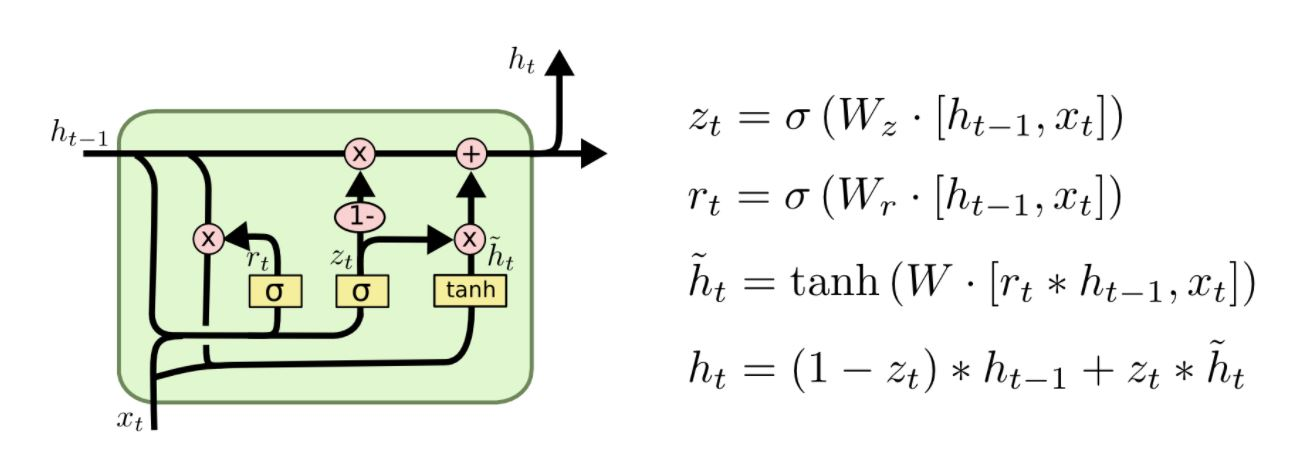

In [3]:
time_step = 10 ## batch 사이즈는 100개가 됨 
sin =np.reshape(sin,[-1,time_step,1]) ## 위 그림 참고 
#(100, 10, 1) 총 1000개 샘플중에서 100줄*10개 time step, hidden layer(state)
print(sin.shape)

(100, 10, 1)


In [4]:
signal = tf.placeholder(tf.float32, shape=[None, time_step,1]) ## 10 timestep *1줄
signal_next = tf.placeholder(tf.float32, shape=[None,1]) ## output 1줄

unstack_signal = tf.unstack(signal,axis=1) ## 1줄로 쫙펴줌 

In [5]:
state_size = 30 ## 30 rows states 
rnn_cell = tf.nn.rnn_cell.BasicRNNCell(num_units = state_size)
states, state = tf.nn.static_rnn(cell=rnn_cell,inputs= unstack_signal,dtype = tf.float32)
## state는 마지막 state를 이야기함 - 다음 RNN에 모델에 넣어쓸수 있음
## outputs, state = tf.rnn.rnn(rnn_cell,X_split,state)

print(states)
for i, _input in enumerate(unstack_signal): ## batch때문에 time_step으로 나눈 입력데이터를 가로로 쫙 리스트로 펴줘야함 
    
    print('unstacked input {}, shape{}'.format(i,_input.shape)) 


[<tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_1:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_2:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_3:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_4:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_5:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_6:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_7:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_8:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'rnn/rnn/basic_rnn_cell/Tanh_9:0' shape=(?, 30) dtype=float32>]
unstacked input 0, shape(?, 1)
unstacked input 1, shape(?, 1)
unstacked input 2, shape(?, 1)
unstacked input 3, shape(?, 1)
unstacked input 4, shape(?, 1)
unstacked input 5, shape(?, 1)
unstacked input 6, shape(?, 1)
unstacked input 7, shape(?, 1)
uns

In [6]:
states = tf.stack(states, axis =1)
reshaped_states = tf.reshape(states, [-1, state_size])
print(reshaped_states) #(?, 30)

Tensor("Reshape:0", shape=(?, 30), dtype=float32)


In [7]:
output = tf.layers.dense(reshaped_states,1,use_bias = False)
print(output) #shape=(?, 1)

Tensor("dense/MatMul:0", shape=(?, 1), dtype=float32)


In [8]:
loss = tf.losses.mean_squared_error(signal_next, output)
train_op = tf.train.GradientDescentOptimizer(1e-2).minimize(loss)

In [9]:
## correlation에 따른 정확도 파악하여 검증하기
## output의 결과와 pred의 결과의 corr를 구한다 
accuracy = tf.contrib.metrics.streaming_pearson_correlation(output,signal_next)

step:0,loss:0.12238795310258865, accuracy(nan, 0.94156247)
step:100,loss:0.015208728611469269, accuracy(0.96125484, 0.96621555)
step:200,loss:0.007233976386487484, accuracy(0.97714794, 0.97722173)
step:300,loss:0.004217912442982197, accuracy(0.98435491, 0.98276031)
step:400,loss:0.0027763587422668934, accuracy(0.9860822, 0.98610932)
step:500,loss:0.001978375716134906, accuracy(0.98833644, 0.98835516)
step:600,loss:0.0014878911897540092, accuracy(0.98995423, 0.98996818)
step:700,loss:0.001162037835456431, accuracy(0.99046814, 0.99118602)
step:800,loss:0.0009327760781161487, accuracy(0.99212891, 0.99213737)
step:900,loss:0.0007645729347132146, accuracy(0.99344659, 0.99290192)


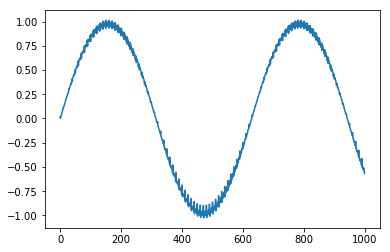

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for i in range(1000):
        _,_loss,_acc = sess.run([train_op, loss,accuracy], feed_dict={signal: sin, signal_next: sin_next})
        
        if i % 100 ==0:
            print('step:{},loss:{}, accuracy{}'.format(i,_loss,_acc))
            
    _pred = sess.run(output, feed_dict={signal: sin})
    _reshaped_pred = np.reshape(_pred, [-1])
    plt.plot(_reshaped_pred)
    plt.show()
        
            